In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# 处理中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 坐标轴负号的处理
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
# ------------------- 第一步：数据预处理与计算 (使用您提供的改进方法) -------------------
# 读取数据
df = pd.read_excel('附件1.xlsx', sheet_name='性能数据表')

# 向下填充合并单元格
df['催化剂组合编号'] = df['催化剂组合编号'].ffill()
df['催化剂组合'] = df['催化剂组合'].ffill()

# 清理列名
df.columns = df.columns.str.strip().str.replace('\n', '').str.replace('\r', '')

# 存储清洗后的数据
data_rows = []

# 用于保存当前催化剂组合的解析结果
current_id = None
current_info = {}

for idx, row in df.iterrows():
    # 判断是否为新的催化剂组合：该行有“编号”且“催化剂组合”字符串中包含"mg"
    if pd.notna(row['催化剂组合编号']) and 'mg' in str(row['催化剂组合']):
        current_id = row['催化剂组合编号']
        combo_str = row['催化剂组合']

        # 使用正则表达式精确解析信息
        co_match = re.search(r'(\d+\.?\d*)wt%Co/SiO2', combo_str)
        co_loading = float(co_match.group(1)) if co_match else np.nan

        co_sio2_match = re.search(r'(\d+)mg\s+[^\s]+Co/SiO2', combo_str)
        co_sio2_mass = float(co_sio2_match.group(1)) if co_sio2_match else np.nan

        hap_match = re.search(r'(\d+)mg\s+HAP', combo_str)
        hap_mass = float(hap_match.group(1)) if hap_match else 0
        has_hap = 1 if hap_match else 0  # 1表示有HAP，0表示无

        ethanol_match = re.search(r'乙醇浓度\s*(\d+\.?\d*)\s*ml/min', combo_str)
        ethanol_conc = float(ethanol_match.group(1)) if ethanol_match else np.nan

        total_mass = co_sio2_mass + hap_mass
        # 计算装料比: Co/SiO2 : HAP
        mass_ratio = f"{co_sio2_mass}:{hap_mass}" if hap_mass != 0 else f"{co_sio2_mass}:0"
        # 计算HAP的质量分数，作为数值特征
        hap_mass_fraction = hap_mass / total_mass if total_mass > 0 else 0

        current_info = {
            '催化剂组合编号': current_id,
            'Co负载量(wt%)': co_loading,
            'Co/SiO2质量(mg)': co_sio2_mass,
            'HAP质量(mg)': hap_mass,
            '总质量(mg)': total_mass,
            '装料比(Co/SiO2:HAP)': mass_ratio,  # 保留原始比例字符串，便于查看
            'HAP质量分数': hap_mass_fraction,  # 使用质量分数作为建模特征
            '乙醇浓度(ml/min)': ethanol_conc,
            '装料方式': 'I' if str(current_id).startswith('A') else 'II',
            '有无HAP': has_hap
        }

    # 无论是否是新组合，只要该行有有效的温度数据，就创建一条记录
    if pd.notna(row.get('温度')) and np.isfinite(row['温度']):
        # 创建一条新记录，包含当前的催化剂信息和当前行的性能数据
        record = current_info.copy()  # 复制当前催化剂信息
        record['温度'] = row['温度']
        record['乙醇转化率(%)'] = row['乙醇转化率(%)']
        record['C4烯烃选择性(%)'] = row['C4烯烃选择性(%)']

        # 只有当性能数据存在时才添加，避免添加空行
        if pd.notna(record['乙醇转化率(%)']) and pd.notna(record['C4烯烃选择性(%)']):
            data_rows.append(record)

# 将列表转换为DataFrame
df_clean = pd.DataFrame(data_rows)

# 计算 C4烯烃收率 (收率 = 转化率 * 选择性 / 100)
df_clean['C4烯烃收率(%)'] = df_clean['乙醇转化率(%)'] * df_clean['C4烯烃选择性(%)'] / 100

# 显示处理后的数据前几行
print("数据预处理完成，前5行数据：")
print(df_clean[['催化剂组合编号', '温度', '乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率(%)', 
                'Co负载量(wt%)', 'HAP质量分数', '乙醇浓度(ml/min)', '装料方式']].head())
print("\n" + "="*80 + "\n")

数据预处理完成，前5行数据：
  催化剂组合编号   温度   乙醇转化率(%)  C4烯烃选择性(%)  C4烯烃收率(%)  Co负载量(wt%)  HAP质量分数  \
0      A1  250   2.067169       34.05   0.703871         1.0      0.5   
1      A1  275   5.851721       37.43   2.190299         1.0      0.5   
2      A1  300  14.968891       46.94   7.026398         1.0      0.5   
3      A1  325  19.681359       49.70   9.781635         1.0      0.5   
4      A1  350  36.801017       47.21  17.373760         1.0      0.5   

   乙醇浓度(ml/min) 装料方式  
0          1.68    I  
1          1.68    I  
2          1.68    I  
3          1.68    I  
4          1.68    I  




In [30]:
# ------------------- 第二步：全局最优解分析 -------------------
print("【问题(3)第一部分：全局最优解】")

# 找到C4烯烃收率最高的实验
max_yield_row = df_clean.loc[df_clean['C4烯烃收率(%)'].idxmax()]
max_yield = max_yield_row['C4烯烃收率(%)']
optimal_combo = max_yield_row['催化剂组合编号']
optimal_temp = max_yield_row['温度']

print(f"在所有实验条件下，C4烯烃收率最高的为 {max_yield:.2f}%。")
print(f"最优条件为：催化剂组合 {optimal_combo}，温度 {optimal_temp}°C。")
print(f"详细信息：")
print(f"  - 乙醇转化率: {max_yield_row['乙醇转化率(%)']:.2f}%")
print(f"  - C4烯烃选择性: {max_yield_row['C4烯烃选择性(%)']:.2f}%")
print(f"  - Co负载量: {max_yield_row['Co负载量(wt%)']}wt%")
print(f"  - HAP质量分数: {max_yield_row['HAP质量分数']:.3f}")
print(f"  - 乙醇浓度: {max_yield_row['乙醇浓度(ml/min)']} ml/min")

print("\n" + "="*80 + "\n")

【问题(3)第一部分：全局最优解】
在所有实验条件下，C4烯烃收率最高的为 44.73%。
最优条件为：催化剂组合 A3，温度 400°C。
详细信息：
  - 乙醇转化率: 83.71%
  - C4烯烃选择性: 53.43%
  - Co负载量: 1.0wt%
  - HAP质量分数: 0.500
  - 乙醇浓度: 0.9 ml/min




In [31]:
# ------------------- 第三步：低温约束下的最优解分析 -------------------
print("【问题(3)第二部分：温度低于350°C的最优解】")

# 筛选温度低于350°C的数据
df_low_temp = df_clean[df_clean['温度'] < 350].copy()

# 找到低温下C4烯烃收率最高的实验
if not df_low_temp.empty:
    max_yield_low_row = df_low_temp.loc[df_low_temp['C4烯烃收率(%)'].idxmax()]
    max_yield_low = max_yield_low_row['C4烯烃收率(%)']
    optimal_combo_low = max_yield_low_row['催化剂组合编号']
    optimal_temp_low = max_yield_low_row['温度']

    print(f"在温度低于350°C的条件下，C4烯烃收率最高的为 {max_yield_low:.2f}%。")
    print(f"最优条件为：催化剂组合 {optimal_combo_low}，温度 {optimal_temp_low}°C。")
    print(f"详细信息：")
    print(f"  - 乙醇转化率: {max_yield_low_row['乙醇转化率(%)']:.2f}%")
    print(f"  - C4烯烃选择性: {max_yield_low_row['C4烯烃选择性(%)']:.2f}%")
    print(f"  - Co负载量: {max_yield_low_row['Co负载量(wt%)']}wt%")
    print(f"  - HAP质量分数: {max_yield_low_row['HAP质量分数']:.3f}")
    print(f"  - 乙醇浓度: {max_yield_low_row['乙醇浓度(ml/min)']} ml/min")
else:
    print("错误：未找到温度低于350°C的数据。")

print("\n" + "="*80 + "\n")

【问题(3)第二部分：温度低于350°C的最优解】
在温度低于350°C的条件下，C4烯烃收率最高的为 17.26%。
最优条件为：催化剂组合 A2，温度 325°C。
详细信息：
  - 乙醇转化率: 56.38%
  - C4烯烃选择性: 30.62%
  - Co负载量: 2.0wt%
  - HAP质量分数: 0.500
  - 乙醇浓度: 1.68 ml/min




【深入分析与模型构建】


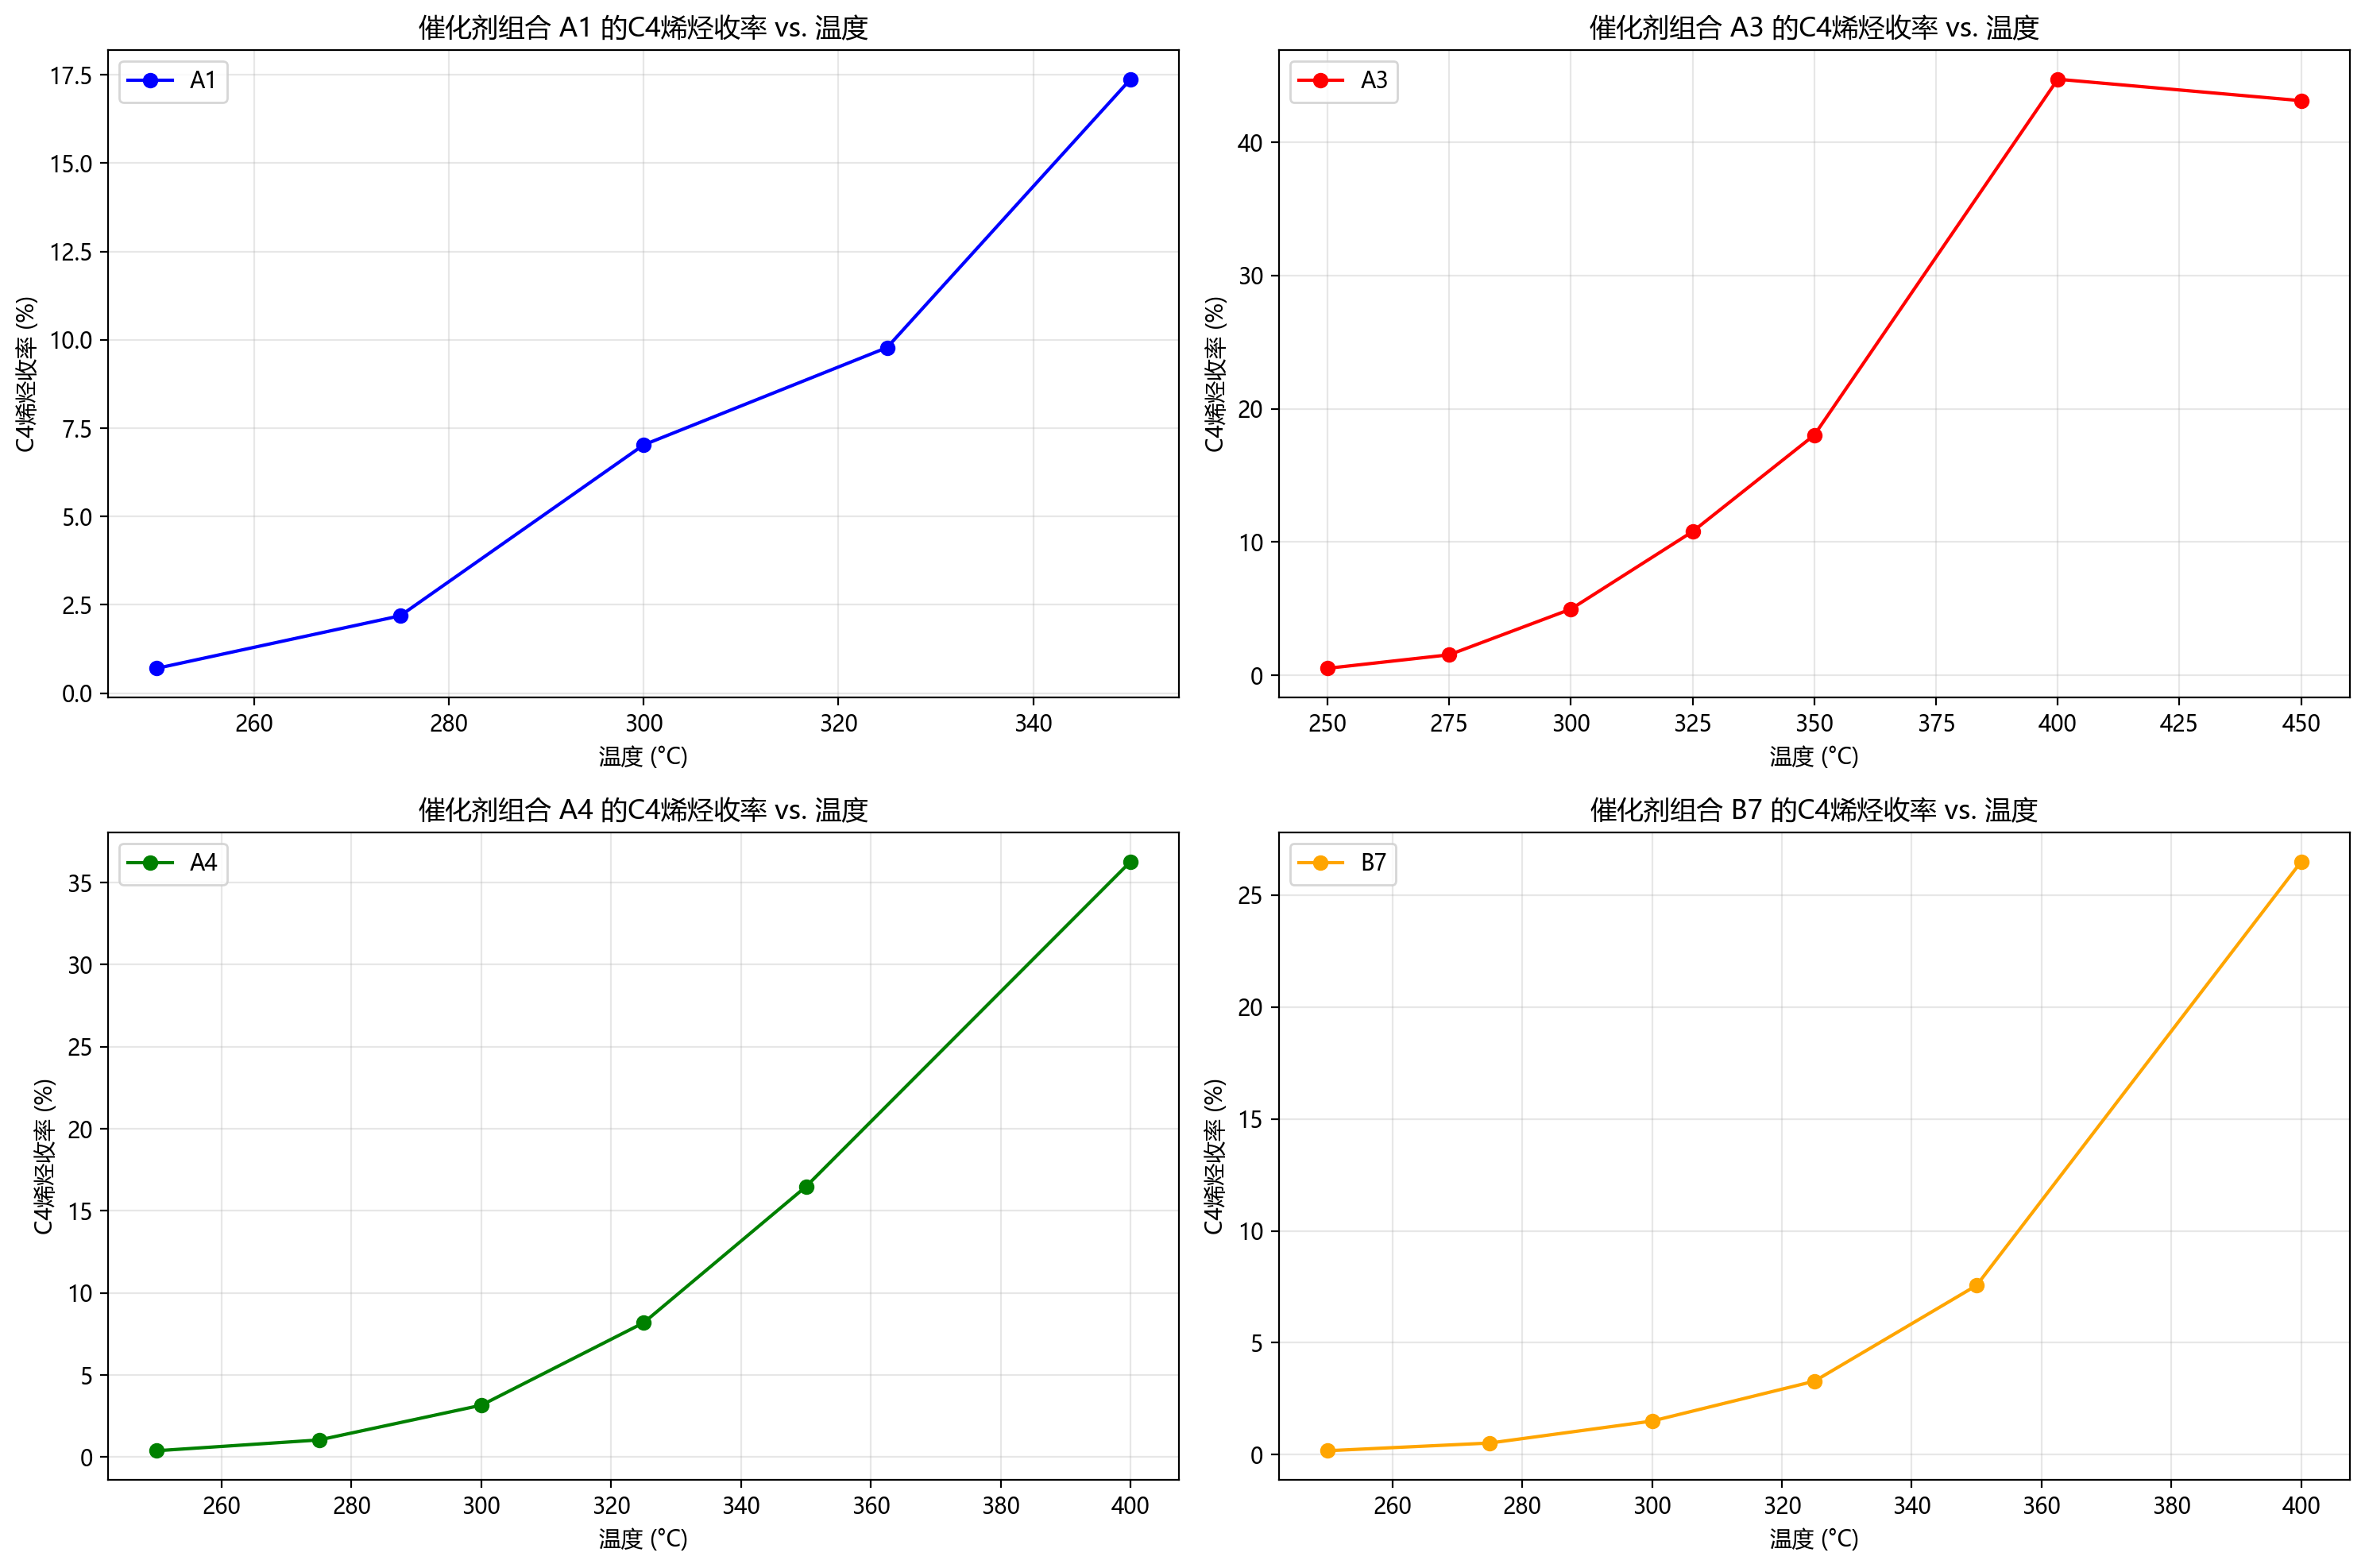

In [ ]:
# ------------------- 第四步：深入分析与模型构建 -------------------
print("【深入分析与模型构建】")

# 4.1 绘制关键组合的收率-温度曲线
plt.figure(figsize=(15, 10))

# 选择几个有代表性的组合进行绘图
key_combos = ['A1', 'A3', 'A4', 'B7']  # 可以根据需要调整
colors = ['blue', 'red', 'green', 'orange']

for idx, combo in enumerate(key_combos):
    data_combo = df_clean[df_clean['催化剂组合编号'] == combo].sort_values('温度')
    if not data_combo.empty:
        plt.subplot(2, 2, idx+1)
        plt.plot(data_combo['温度'], data_combo['C4烯烃收率(%)'], marker='o', color=colors[idx], label=combo)
        plt.xlabel('温度 (°C)')
        plt.ylabel('C4烯烃收率 (%)')
        plt.title(f'催化剂组合 {combo} 的C4烯烃收率 vs. 温度')
        plt.grid(True, alpha=0.3)
        plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# 4.2 建立多项式回归模型
print("\n【建立多项式回归模型】")

# 准备特征和目标变量
# 使用数值型特征：Co负载量、HAP质量分数、乙醇浓度、温度
features = ['Co负载量(wt%)', 'HAP质量分数', '乙醇浓度(ml/min)', '温度']
X = df_clean[features]
y = df_clean['C4烯烃收率(%)']

# 创建一个包含多项式特征和线性回归的管道
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # 二次多项式
    ('linear', LinearRegression())
])

# 训练模型
model.fit(X, y)

# 预测和评估
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"模型R²得分: {r2:.4f}")


【建立多项式回归模型】
模型R²得分: 0.7319


In [34]:
# 4.3 模型验证：用模型预测全局最优解
print("\n【模型验证】")
# 让模型预测所有数据点的收率，并找出预测值最高的点
df_clean['模型预测收率(%)'] = model.predict(X)
max_pred_row = df_clean.loc[df_clean['模型预测收率(%)'].idxmax()]
print(f"模型预测的全局最优组合为: {max_pred_row['催化剂组合编号']} @ {max_pred_row['温度']}°C")
print(f"真实收率: {max_pred_row['C4烯烃收率(%)']:.2f}%, 模型预测值: {max_pred_row['模型预测收率(%)']:.2f}%")


【模型验证】
模型预测的全局最优组合为: A3 @ 450°C
真实收率: 43.12%, 模型预测值: 43.06%


In [35]:
# 4.4 特征重要性分析
linear_reg = model.named_steps['linear']
poly_features = model.named_steps['poly']
feature_names = poly_features.get_feature_names_out(features)

# 获取线性回归的系数
coefficients = linear_reg.coef_

print("\n【多项式模型特征系数 (前10个)】")
for name, coef in zip(feature_names[:10], coefficients[:10]):
    print(f"  {name}: {coef:8.3f}")

# 重点分析主效应（一次项）
print("\n【特征主效应分析 (一次项系数)】")
linear_coefficients = coefficients[:len(features)]  # 前4个是原始特征的一次项
for name, coef in zip(features, linear_coefficients):
    effect = "正向" if coef > 0 else "负向"
    print(f"  {name}: 系数 = {coef:6.3f}, 影响 = {effect}")

print("\n注意：'温度'的二次项通常为负，解释了收率随温度先增后减的现象。")


【多项式模型特征系数 (前10个)】
  Co负载量(wt%):    6.241
  HAP质量分数:  -10.668
  乙醇浓度(ml/min):   31.282
  温度:   -0.463
  Co负载量(wt%)^2:   -0.181
  Co负载量(wt%) HAP质量分数:   -7.547
  Co负载量(wt%) 乙醇浓度(ml/min):   -0.654
  Co负载量(wt%) 温度:   -0.000
  HAP质量分数^2:  -32.907
  HAP质量分数 乙醇浓度(ml/min):   -2.281

【特征主效应分析 (一次项系数)】
  Co负载量(wt%): 系数 =  6.241, 影响 = 正向
  HAP质量分数: 系数 = -10.668, 影响 = 负向
  乙醇浓度(ml/min): 系数 = 31.282, 影响 = 正向
  温度: 系数 = -0.463, 影响 = 负向

注意：'温度'的二次项通常为负，解释了收率随温度先增后减的现象。


In [36]:
# 4.5 预测低温最优解
print("\n【低温约束下的模型预测】")
df_low_temp['模型预测收率(%)'] = model.predict(df_low_temp[features])
max_pred_low_row = df_low_temp.loc[df_low_temp['模型预测收率(%)'].idxmax()]
print(f"模型预测的低温(350°C以下)最优组合为: {max_pred_low_row['催化剂组合编号']} @ {max_pred_low_row['温度']}°C")
print(f"真实收率: {max_pred_low_row['C4烯烃收率(%)']:.2f}%, 模型预测值: {max_pred_low_row['模型预测收率(%)']:.2f}%")

print("\n分析完成。")


【低温约束下的模型预测】
模型预测的低温(350°C以下)最优组合为: A5 @ 325°C
真实收率: 3.93%, 模型预测值: 8.14%

分析完成。


In [40]:
print("\n" + "="*80 + "\n")
print("【高级分析：寻找理论上的全局最优条件】")
print("使用训练好的多项式回归模型，在参数空间内进行网格搜索。")

# 定义搜索的参数范围
# 这些范围基于附件1中出现的值
co_loading_range = np.linspace(0.5, 5, 10)   # Co负载量: 0.5wt% 到 5wt%
hap_fraction_range = np.linspace(0, 1, 11)    # HAP质量分数: 0 (无HAP) 到 1 (全是HAP)
ethanol_conc_range = np.linspace(0.3, 2.1, 7) # 乙醇浓度: 0.3 到 2.1 ml/min
temperature_range = np.linspace(250, 450, 11) # 温度: 250°C 到 450°C

# 创建网格
param_grid = np.array(np.meshgrid(co_loading_range, hap_fraction_range, ethanol_conc_range, temperature_range))
# 将4D网格展平成一个2D数组，每一行是一个参数组合
param_combinations = param_grid.reshape(4, -1).T  # shape: (n_combinations, 4)

print(f"正在搜索 {param_combinations.shape[0]} 个参数组合...")

# 使用模型进行批量预测
predicted_yields = model.predict(param_combinations)

# 找到预测收率最高的点
best_idx = np.argmax(predicted_yields)
best_yield = predicted_yields[best_idx]
best_params = param_combinations[best_idx]

best_co, best_hap_frac, best_ethanol, best_temp = best_params

print(f"\n理论上的全局最优条件为：")
print(f"  - Co负载量: {best_co:.2f} wt%")
print(f"  - HAP质量分数: {best_hap_frac:.3f}")
print(f"  - 乙醇浓度: {best_ethanol:.2f} ml/min")
print(f"  - 温度: {best_temp:.1f} °C")
print(f"  - 预测的C4烯烃收率: {best_yield:.2f}%")

# 计算对应的装料比 (假设总质量为100mg，仅用于展示比例)
# Co/SiO2质量 = (1 - best_hap_frac) * 100
# HAP质量 = best_hap_frac * 100



【高级分析：寻找理论上的全局最优条件】
使用训练好的多项式回归模型，在参数空间内进行网格搜索。
正在搜索 8470 个参数组合...

理论上的全局最优条件为：
  - Co负载量: 5.00 wt%
  - HAP质量分数: 0.400
  - 乙醇浓度: 0.30 ml/min
  - 温度: 450.0 °C
  - 预测的C4烯烃收率: 52.03%


c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [38]:
# ------------------- 第五步：寻找理论上的最优条件 -------------------
print("\n" + "="*80 + "\n")
print("【高级分析：寻找理论上的最优条件】")

# 定义搜索范围
co_loading_range = np.linspace(0.5, 5, 10)
hap_fraction_range = np.linspace(0, 1, 11)
ethanol_conc_range = np.linspace(0.3, 2.1, 7)
temperature_range_global = np.linspace(250, 450, 11)  # 全局温度范围
temperature_range_low = np.linspace(250, 350, 11)     # 低温范围

# 1. 寻找全局理论最优解
param_grid_global = np.array(np.meshgrid(co_loading_range, hap_fraction_range, ethanol_conc_range, temperature_range_global))
param_combinations_global = param_grid_global.reshape(4, -1).T

print(f"正在全局范围内搜索 {param_combinations_global.shape[0]} 个参数组合...")

# 关键修改：将数组转换为带有正确列名的DataFrame，消除警告
X_pred_global = pd.DataFrame(param_combinations_global, columns=features)
predicted_yields_global = model.predict(X_pred_global)

best_idx_global = np.argmax(predicted_yields_global)
best_yield_global = predicted_yields_global[best_idx_global]
best_params_global = param_combinations_global[best_idx_global]
best_co, best_hap_frac, best_ethanol, best_temp = best_params_global

print(f"\n理论上的全局最优条件为：")
print(f"  - Co负载量: {best_co:.2f} wt%")
print(f"  - HAP质量分数: {best_hap_frac:.3f}")
print(f"  - 乙醇浓度: {best_ethanol:.2f} ml/min")
print(f"  - 温度: {best_temp:.1f} °C")
print(f"  - 预测的C4烯烃收率: {best_yield_global:.2f}%")



【高级分析：寻找理论上的最优条件】
正在全局范围内搜索 8470 个参数组合...

理论上的全局最优条件为：
  - Co负载量: 5.00 wt%
  - HAP质量分数: 0.400
  - 乙醇浓度: 0.30 ml/min
  - 温度: 450.0 °C
  - 预测的C4烯烃收率: 52.03%


In [39]:
# 2. 寻找低温理论最优解 (新增部分)
param_grid_low = np.array(np.meshgrid(co_loading_range, hap_fraction_range, ethanol_conc_range, temperature_range_low))
param_combinations_low = param_grid_low.reshape(4, -1).T

print(f"\n正在低温(350°C以下)范围内搜索 {param_combinations_low.shape[0]} 个参数组合...")

# 关键修改：将数组转换为带有正确列名的DataFrame，消除警告
X_pred_low = pd.DataFrame(param_combinations_low, columns=features)
predicted_yields_low = model.predict(X_pred_low)

best_idx_low = np.argmax(predicted_yields_low)
best_yield_low = predicted_yields_low[best_idx_low]
best_params_low = param_combinations_low[best_idx_low]
best_co_low, best_hap_frac_low, best_ethanol_low, best_temp_low = best_params_low

print(f"\n理论上的低温最优条件为：")
print(f"  - Co负载量: {best_co_low:.2f} wt%")
print(f"  - HAP质量分数: {best_hap_frac_low:.3f}")
print(f"  - 乙醇浓度: {best_ethanol_low:.2f} ml/min")
print(f"  - 温度: {best_temp_low:.1f} °C")
print(f"  - 预测的C4烯烃收率: {best_yield_low:.2f}%")

print("\n理论最优解分析完成。")


正在低温(350°C以下)范围内搜索 8470 个参数组合...

理论上的低温最优条件为：
  - Co负载量: 5.00 wt%
  - HAP质量分数: 0.100
  - 乙醇浓度: 0.30 ml/min
  - 温度: 350.0 °C
  - 预测的C4烯烃收率: 21.70%

理论最优解分析完成。
